# Table of Contents
<div class="toc" style="margin-top: 1em;">
   <ul class="toc-item" id="toc-level0">
      <li>
         <span><a href="#API-Overview" data-toc-modified-id="API-Overview-1"><span class="toc-item-num">1.&nbsp;&nbsp;</span>API Overview</a></span>
         <ul class="toc-item">
            <li><span><a href="#Context" data-toc-modified-id="Context-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Context</a></span></li>
            <li><span><a href="#Creating-a-ClipperConnection" data-toc-modified-id="Create-a-ClipperConnection-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Creating a ClipperConnection</a></span></li>
            <li><span><a href="#Starting-Clipper" data-toc-modified-id="Starting-Clipper-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Starting Clipper</a></span></li>
            <li>
               <span><a href="#Deploying-a-model" data-toc-modified-id="Deploying-a-model-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Deploying a model</a></span>
               <ul class="toc-item">
                  <li>
                     <span><a href="#Creating-a-model" data-toc-modified-id="Create-the-model-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Creating a model</a></span>
                  </li>
                  <li><span><a href="#Deploying-to-Clipper" data-toc-modified-id="Deploying-to-Clipper-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Deploying to Clipper</a></span></li>
                  <li><span><a href="#A-Note-About-Types-[Optional]" data-toc-modified-id="A-Note-About-Types-[Optional]-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>A Note About Types [Optional]</a></span></li>
               </ul>
            </li>
            <li><span><a href="#Registering-an-Application" data-toc-modified-id="Registering-an-Application-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Registering an Application</a></span></li>
            <li><span><a href="#Inspecting-Clipper" data-toc-modified-id="Inspecting-Clipper-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Inspecting Clipper</a></span></li>
            <li><span><a href="#Updating-the-Model" data-toc-modified-id="Updating-the-Model-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Updating the Model</a></span></li>
            <li><span><a href="#Adding-Model-Replicas" data-toc-modified-id="Adding-Model-Replicas-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Adding Model Replicas</a></span></li>
         </ul>
      </li>
<li>
         <span><a href="#Example-Application---Image-Classification" data-toc-modified-id="Example-Application---Image-Classification"><span class="toc-item-num">2.&nbsp;&nbsp;</span>Example Application - Image Classification</a></span>
      <li><span><a href="#Example-Application---Custom-Docker-Containers" data-toc-modified-id="Example-Application---Custom-Docker-Containers"><span class="toc-item-num">3.&nbsp;&nbsp;</span>Example Application - Custom Docker Containers</a></span></li>
      <li><span><a href="#Restarting-Clipper" data-toc-modified-id="Restarting-Clipper"><span class="toc-item-num">4.&nbsp;&nbsp;</span>Restarting Clipper</a></span></li>
   </ul>
</div>

<a id='api_overview'></a>
## API Overview

In the first part of this exercise, you will explore how to create and interact with a Clipper cluster. The primary way of managing Clipper is with the Clipper Admin Python tool. This tutorial will walk you through all the things you can do with the Clipper Admin tool as well as explain what happens within Clipper when you issue each command. You can find the complete API documentation for the Clipper Admin tool on our website: <http://docs.clipper.ai>.

**Goal:** Be familiar with how to create and manage a Clipper cluster, and understand what happens when you issue Clipper admin commands.

### Context
The Clipper Admin tool is distributed through Pip. You can install it with `pip install clipper_admin`, but it has already been installed in this notebook for you, in the first cell.

Clipper is built on top of Docker containers. A running Clipper cluster consists of a collection of Docker containers communicating with each other over the network. As you issue commands against Clipper, you are communicating with these containers as well as creating new ones or destroying existing ones. As you explore the Clipper API throughout this exercise, we will illustrate how each command effects the cluster state.

The main API for interacting with Clipper is exposed via a [`ClipperConnection`](http://docs.clipper.ai/en/develop/#clipper-connection) object. This is your handle to a Clipper cluster (this collection of Docker containers). It can be used to start, stop, inspect, and modify the cluster.

In order to create a `ClipperConnection` object, you must provide it with a [`ContainerManager`](http://docs.clipper.ai/en/develop/#container-managers) object. While Docker is becoming an increasingly standard mechanism for deploying applications, there are many different tools for managing a Docker cluster. These tools broadly fall into the category of *Container Orchestration frameworks*. Some popular examples are [Kubernetes](https://kubernetes.io/), [Docker Swarm](https://docs.docker.com/engine/swarm/), and [DC/OS](https://dcos.io/). One of the reasons we run Clipper in Docker containers is to make the system as general as possible and support many different deployment scenarios. Within the Clipper Admin, we abstract away all of the Docker container-specific commands behind the `ContainerManager` interface. The `ClipperConnection` object makes Clipper-specific decisions about how to issue commands, and then makes any changes to the Docker configuration (for example, to launch a container for a newly deployed model) through the `ContainerManager`. To support different container orchestration frameworks that manage Docker containers in different ways, we create different implementations of the `ContainerManager` interface.

Clipper currently provides two `ContainerManager` implementations: the `DockerContainerManager` and the `KubernetesContainerManager`. In this exercise, you will be using the `DockerContainerManager`, which runs Clipper directly on your local Docker instance. This `ContainerManager` is particularly useful for trying out Clipper without needing to set up an enterprise-grade container orchestration framework. The `DockerContainerManager` is not recommended for production use cases.

### Creating a ClipperConnection
To beginn using Clipper, we must first create a [`ClipperConnection`](http://docs.clipper.ai/en/develop/#clipper-connection) object. With the type of `ContainerManager` you want to use. It is important to note that creating a new connection object does not connect to Clipper - a good thing because there is no running Clipper instance to connect to!

Before we connect, we need to start Clipper - which we will address in the next step.

Returning to the process of creating a new connection object, we realize that the first step is to create a `DockerContainerManager` object. The `DockerContainerManager` constructor takes `docker_ip_address` as a keyword argument. Generally, since we want the Clipper cluster to be run locally, we can omit this argument, as its default value is `127.0.0.1`, which will suit our purposes in this case as well.

In [1]:
from clipper_admin import ClipperConnection, DockerContainerManager
clipper_conn = ClipperConnection(DockerContainerManager())

### Starting Clipper
Now that we have a `ClipperConnection` object, we must start Clipper to provide it an endpoint to connect to.

This command will start 3 Docker containers:
1. The Query Frontend: The Query Frontend container listens for incoming prediction requests and schedules and routes them to the deployed models. In the future, it will also be able to call user defined model selection policies on prediction requests to decide which models to route to.
2. The Management Frontend: The Management Frontend container manages and updates Clipper's internal configuration state.
3. A Redis instance: Redis is used to persistently store Clipper's internal configuration state. Redis is started on port 6380 instead of the default port to avoid collisions with any Redis instances that are already running.

The containers network together as illustrated below:
![title](img/start_clipper.png)

> *Because Docker must download the Docker images from the internet (if they are not already cached) before it can start the containers, the first time you run this command can take a long time to complete (up to a couple minutes) while the image is downloaded. Thanks for your patience.*

If you try to start more than one Clipper cluster at once on the same host, the second execution of the command will fail because, by default, the second cluster will try to bind to the same ports as the first one. If you run into problems with the exercise and want to start over, see instructions on how to reset Clipper.

In [3]:
clipper_conn.stop_all()

18-09-07:02:15:28 INFO     [clipper_admin.py:1258] Stopped all Clipper cluster and all model containers


In [4]:
clipper_conn.start_clipper()
clipper_addr = clipper_conn.get_query_addr()

18-09-07:02:15:28 INFO     [docker_container_manager.py:119] Starting managed Redis instance in Docker
18-09-07:02:15:30 INFO     [clipper_admin.py:126] Clipper is running


### Deploying a model
At its most basic, a trained model is just a function that takes some input and produces some output. As a result, one way to think about Clipper is as a function server. While these functions are often complex models, Clipper is not restricted to serving machine learning models.

Deploying a model consists of two steps:
1. Creating the model - Before a model can be deployed, it must first be written and trained.
2. Deploying the model - Clipper offers a wide variety of deployers for standard ML packages to make deployment easier. In addition, it is possible to deploy packages such as XGBoost or Scikit-Learn using the default PythonClosureContainer, by specifying what packages to install, or to create your own model container.

To start with, you will deploy a very simple model to Clipper. We'll start by clustering data with Scikit-Learn!

#### Creating a model
We start by creating and training our model, which will be an 3 way classifier from sklearn.

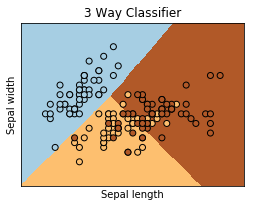

In [8]:
# The code to train the model and produce the graph comes from this sklearn example:
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
%matplotlib inline

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data[:, :2]  # We only take the first two features.
Y = iris.target

h = .02  # Step size in the mesh

model = linear_model.LogisticRegression(C=1e5)

# We create an instance of Neighbours Classifier and fit the data.
model.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('3 Way Classifier')
plt.show()

Now that we have a model, we need to create the function that we will deploy to Clipper. We know that our function takes an array of length 2 - a petal width and a sepal length - and returns a label, so we can just define our `predict_label` function as shown below:

In [9]:
def predict_label(flower):
    if (len(flower) != 2):
        return 'Invalid argument passed!'
    return model.predict(flower)

To improve performance during inference, many machine learning models exploit opportunities for data parallelism in the inference process. Because of this, Clipper tries to provide multiple inputs at once to a deployed model. Therefore, models deployed to Clipper must have a function interface that takes a list of inputs as an argument and returns a list of predictions as strings. Returning predictions as strings provides a lot of flexibility over what your models can return. Commonly, models in Clipper will return either a single number (such as a label or score) or JSON containing a richer representation of the model output (for example, by including confidence estimates of predicted labels).

Starting version 0.3.0, Clipper not only supports batching, but also performs adaptive batching. To perform adaptive batching, Clipper sends different batch sizes to models in order to determine which batch size is optimal, and therefore it is imperative to treat the input to the predict function as a batch. We will go into more detail about using batching with Clipper in a later section.

We redefine our `predict_label` function, this time calling it `predict_flower`, to support this API. Since we are returning a string anyways, we might as well convert the labels given to us by our model to the corresponding flower name.

In [10]:
def predict_flower(flowers):
    labels = model.predict(flowers)
    return ['Setosa' if l == 0 else 'Versicolour' if l == 2 else 'Virginica' for l in labels]

Now that we have a valid function, we proceed to the deployment stage!

In [11]:
# Just a quick test
assert predict_flower([X[0], X[101]]) == ['Setosa', 'Virginica']

#### Deploying to Clipper

One of the goals of Clipper is to make it simple to deploy and maintain machine-learning models in production. The prediction interface that models must implement is very simple, consisting of a single function. And the use of Docker makes it easy to include all of a model's dependencies in a self-contained environment. However, deploying a new type of model still entails writing and debugging a new model container and creating a Docker image.
To make the model deployment process even simpler, Clipper provides a library of model deployers for common types of models. If your model can be deployed with one of these deployers, you no longer need to write a model container, create a Docker image, or even figure out how to save a model. Instead, you provide your trained model directly to the model deployer function within your Python process. The model deployer takes care of saving the model and building a Docker image that is compatible with your model type.

Clipper provides model deployers for many common ML packages including PySpark, ONNX, TensorFlow, etc. In addition, Clipper provides a model deployer (the `PythonClosureContainer`) that can deploy arbitrary Python functions, and the ability to write custom containers for unsupported models.

To keep the base images light, Clipper model containers install only the required dependencies to ensure that a basic model will run. Starting in version 0.3.0, users are also offered the ability to specify packages to install via pip on new model containers during their startup using the `pkgs_to_install` keyword argument. This feature is in all model containers, and today, we will use it with the `PythonClosureContainer` to deploy our Scikit-Learn model.

Some models, such as those provided by Scikit-Learn or XGBoost, can be pickled, and require only that the packages are installed, and so these models can be deployed using the `PythonClosureContainer` and specifying that the packages are installed via the `pkgs_to_install` keyword argument, rather than creating custom model deployment containers.

For more information about model deployers, check out the docs on our [site](http://clipper.ai)!

In [12]:
from clipper_admin.deployers import python as python_deployer
python_deployer.deploy_python_closure(
    clipper_conn,
    name="flowercat",  # The name of the model in Clipper
    version=1,  # A unique identifier to assign to this model.
    input_type="floats",  # The type of data the model function expects as input
    func=predict_flower, # The model function to deploy
    pkgs_to_install=['numpy', 'scipy', 'scikit-learn'] # Packages to install in the new container. Must be a list
)

18-09-07:02:16:07 INFO     [deployer_utils.py:44] Saving function to /tmp/clipper/tmpxd42yrvx
18-09-07:02:16:07 INFO     [deployer_utils.py:54] Serialized and supplied predict function
18-09-07:02:16:07 INFO     [python.py:192] Python closure saved
18-09-07:02:16:07 INFO     [python.py:206] Using Python 3.6 base image
18-09-07:02:16:07 INFO     [clipper_admin.py:452] Building model Docker image with model data from /tmp/clipper/tmpxd42yrvx
18-09-07:02:16:17 INFO     [clipper_admin.py:456] {'stream': 'Step 1/3 : FROM clipper/python36-closure-container:0.3.0'}
18-09-07:02:16:17 INFO     [clipper_admin.py:456] {'stream': '\n'}
18-09-07:02:16:17 INFO     [clipper_admin.py:456] {'stream': ' ---> 74ba26b9a6ba\n'}
18-09-07:02:16:17 INFO     [clipper_admin.py:456] {'stream': 'Step 2/3 : COPY /tmp/clipper/tmpxd42yrvx /model/'}
18-09-07:02:16:17 INFO     [clipper_admin.py:456] {'stream': '\n'}
18-09-07:02:16:17 INFO     [clipper_admin.py:456] {'stream': ' ---> ff807d419289\n'}
18-09-07:02:16:17 

Clipper deploys each model in its own Docker container. After deploying the model, Clipper uses the DockerContainerManager to start a container for this model and create an RPC connection with the Clipper query frontend, as illustrated below (the changes to the cluster are highlighted in red).

> *Once again, Clipper must download a Docker container from the internet the first time this command is run.*

![title](img/deploy_model.png)

If you list the Clipper containers again, you can see the container running your word count model.

In [13]:
!docker ps --filter label=ai.clipper.container.label

CONTAINER ID        IMAGE                               COMMAND                  CREATED             STATUS                   PORTS                                            NAMES
59b6b53a53c6        flowercat:1                         "/container/containe…"   6 seconds ago       Up 6 seconds (healthy)                                                    flowercat_1-28276
2ed173debbcf        prom/prometheus:v2.1.0              "/bin/prometheus --c…"   55 seconds ago      Up 54 seconds            0.0.0.0:9090->9090/tcp                           metric_frontend-30516
5f7b0adf1413        clipper/frontend-exporter:0.3.0     "python /usr/src/app…"   55 seconds ago      Up 55 seconds                                                             query_frontend_exporter-16813
0b61be787c33        clipper/query_frontend:0.3.0        "/clipper/release/sr…"   56 seconds ago      Up 55 seconds            0.0.0.0:1337->1337/tcp, 0.0.0.0:7000->7000/tcp   query_frontend-16813
d259e89b55a7        clipper/

##### A Note About Types [Optional]
When you deploy models and register applications, you must specify the input type that the model or application expects. The type that you specify has implications for how Clipper manages input serialization and deserialization. From the user's perspective, the input type affects the behavior of Clipper in two places. In the "input" field of the request JSON body, applications will reject requests where the value of that field is the wrong type. And the deployed model function will be called with a list of inputs of the specified type.

The input type can be one of the following types:

* "ints": The value of the "input" field in a request must be a JSON list of ints. The model function will be called with a list of numpy arrays of type numpy.int.
* "floats": The value of the "input" field in a request must be a JSON list of doubles. The model function will be called with a list of numpy arrays of type numpy.float32.
* "doubles": The value of the "input" field in a request must be a JSON list of doubles. The model function will be called with a list of numpy arrays of type numpy.float64.
* "bytes": The value of the "input" field in a request must be a Base64 encoded string. The model function will be called with a list of numpy arrays of type numpy.int8.
* "strings": The value of the "input" field in a request must be a string. The model function will be called with a list of strings.

### Registering an Application
You've now deployed a model to Clipper, but you don't have any way to query it yet. Instead of automatically creating a REST endpoint when you deploy a model, Clipper introduces a layer of indirection: the application. Clients query a specific application in Clipper, and the application routes the query to the correct model. This allows multiple applications to route queries to the same model, and allows a single application to route queries to multiple models.

A single Clipper cluster can have many applications registered and many models deployed at once.

When you register an application you configure certain elements of the application's behavior. These include:

* The name to give the REST endpoint.
* The input type that the application expects (Clipper will ensure applications only route requests to models with matching input types).
* The latency service level objective (SLO) specified in microseconds. Clipper will manage how it schedules and routes queries for an application based on the specified service level objective. For example, Clipper will set the amount of time it allows requests to spend queued before being sent to the model based on the service level objective for the application requesting the prediction. In addition, Clipper will respond to requests by the end of the specified SLO, even if it has not received a prediction back from the model.
* The default output: Clipper will respond with the default output to requests if a real prediction isn't available by the end of the service level objective.
* (In the future) The selection policy: The default or user defined model selection policy to use when determining which models to route requests to.

When you register an application with Clipper, it creates a REST endpoint for that application:

```
URL: /<app_name>/predict
Method: POST
Data Params: {"input": <input>}
```

To provide batch requests to clipper, you simply substitute `input` with `input_batch`. If both appear, `input` will be used, and `input_batch` ignored.

```
URL: /<app_name>/predict
Method: POST
Data Params: {"input_batch": <input_batch>}
```

![title](img/register_app.png)

Register an application to query your classifier:

In [14]:
clipper_conn.register_application(
    name="flowercat-app",
    input_type="floats",
    default_output="Default",
    slo_micros=100000)

18-09-07:02:16:27 INFO     [clipper_admin.py:201] Application flowercat-app was successfully registered


Try querying the newly created application. We use Python in this example, but it can also be done with [curl](https://curl.haxx.se)!

In [15]:
import requests, json
response = requests.post(
     "http://%s/%s/predict" % (clipper_addr, 'flowercat-app'),
     headers={"Content-type": "application/json"},
     data=json.dumps({
         'input': list(X[0]),
     }))
result = response.json()
result

{'query_id': 0,
 'output': 'Default',
 'default': True,
 'default_explanation': 'No connected models found for query'}

You should see that your application returned the default output of "Default". This is because even though you have deployed a model and registered an application, you have not told Clipper to route requests from the "flowercat-app" application to the "flowercat" model.

You do this by linking the model to the application.

![title](img/link_model.png)

In [16]:
clipper_conn.link_model_to_app(app_name="flowercat-app", model_name="flowercat")

18-09-07:02:16:30 INFO     [clipper_admin.py:263] Model flowercat is now linked to application flowercat-app


When you query the "wordcount-app" endpoint again, Clipper should return the correct word count. Try it with your own input.

In [17]:
response = requests.post(
     "http://%s/%s/predict" % (clipper_addr, 'flowercat-app'),
     headers={"Content-type": "application/json"},
     data=json.dumps({
         'input': list(X[0]),
     }))
result = response.json()
result

{'query_id': 1, 'output': 'Setosa', 'default': False}

### Inspecting Clipper
The ClipperConnection object has several methods to inspect various aspects of the Clipper cluster.

You can list all of the applications.

In [18]:
clipper_conn.get_all_apps(verbose=True)

[{'input_type': 'floats',
  'default_output': 'Default',
  'latency_slo_micros': 100000,
  'name': 'flowercat-app',
  'linked_models': ['flowercat']}]

Or all of the models.

In [19]:
clipper_conn.get_all_models(verbose=True)

[{'model_name': 'flowercat',
  'model_version': '1',
  'input_type': 'floats',
  'labels': [''],
  'container_name': 'flowercat:1',
  'model_data_path': 'DEPRECATED',
  'is_current_version': True}]

Clipper also tracks several performance metrics that you can inspect at any time, as well as allows you to deploy your own custom metrics.

In [20]:
clipper_conn.inspect_instance()

{'counters': [{'internal:prediction_cache_lookups': {'count': '1'}},
  {'internal:aggregate_num_predictions': {'count': '1'}},
  {'model:flowercat:1:num_predictions': {'count': '2'}},
  {'app:flowercat-app:num_predictions': {'count': '2'}}],
 'ratio_counters': [{'internal:prediction_cache_hit_ratio': {'ratio': '0'}},
  {'model:flowercat:1:cache_hit_ratio': {'ratio': '0'}},
  {'app:flowercat-app:default_prediction_ratio': {'ratio': '0.5'}}],
 'meters': [{'internal:aggregate_model_throughput': {'unit': 'events per second',
    'rate': '0.029374459142771033',
    'rate_1min': '0.031982234148270686',
    'rate_5min': '0.0066114184713530035',
    'rate_15min': '0.0022160607980413085'}},
  {'model:flowercat:1:prediction_throughput': {'unit': 'events per second',
    'rate': '0.11774103001736916',
    'rate_1min': '0.031982234148270686',
    'rate_5min': '0.0066114184713530035',
    'rate_15min': '0.0022160607980413085'}},
  {'app:flowercat-app:prediction_throughput': {'unit': 'events per sec

You can also fetch the raw container logs from all of the Clipper docker containers. The command will print the paths to the log files for further examination. You can figure out which logs belong to which container based on the unique Docker container ID in the log filename.

In [21]:
clipper_conn.get_clipper_logs()

18-09-07:02:16:37 INFO     [docker_container_manager.py:295] Created logging directory: /home/ubuntu/repos/clipper-tutorials-2/clipper_logs


['/home/ubuntu/repos/clipper-tutorials-2/clipper_logs/image_sha256:c8c1a40ffb:container_59b6b53a53.log',
 '/home/ubuntu/repos/clipper-tutorials-2/clipper_logs/image_sha256:c8ecf7c719:container_2ed173debb.log',
 '/home/ubuntu/repos/clipper-tutorials-2/clipper_logs/image_sha256:c29b40eb63:container_5f7b0adf14.log',
 '/home/ubuntu/repos/clipper-tutorials-2/clipper_logs/image_sha256:7eefa1a263:container_0b61be787c.log',
 '/home/ubuntu/repos/clipper-tutorials-2/clipper_logs/image_sha256:3d960da25d:container_d259e89b55.log',
 '/home/ubuntu/repos/clipper-tutorials-2/clipper_logs/image_sha256:756717246f:container_3ae1398559.log']

### Updating the Model
Machine learning models are rarely static. Instead, data science tends to be an iterative process, with new and improved models being developed over time. Clipper supports this workflow by letting you deploy new versions of models. If you look back to where you linked your flowercat model to the application, you'll see that there is no mention of versioning in that method call. Instead, when a new version of a model is deployed, Clipper will automatically start routing requests to the new version.

Create a new version of the "flowercat" model that returns the probabilities that an input is in each class instead.

In [22]:
def new_predict_flower(flowers):
    return model.predict_proba(flowers)

In [23]:
new_predict_flower([X[0]])

array([[0.9058239 , 0.0681672 , 0.02600889]])

Deploy this new version of the function as version "2". For this application, you are using a numeric versioning scheme. But Clipper just treats versions as unique string identifiers, so you could use other versioning schemes (such as Git hashes or semantic versioning). Versions don't even have to be ordered, Clipper just tracks the currently active version.

![title](img/update_model.png)


In [24]:
python_deployer.deploy_python_closure(
    clipper_conn,
    name="flowercat",  # The name of the model in Clipper
    version=2,  # A unique identifier to assign to this model.
    input_type="floats",  # The type of data the model function expects as input
    func=new_predict_flower, # The model function to deploy
    pkgs_to_install=['numpy', 'scipy', 'scikit-learn'] # Packages to install in the new container. Must be a list
)

18-09-07:02:16:43 INFO     [deployer_utils.py:44] Saving function to /tmp/clipper/tmpwd18ua3a
18-09-07:02:16:43 INFO     [deployer_utils.py:54] Serialized and supplied predict function
18-09-07:02:16:43 INFO     [python.py:192] Python closure saved
18-09-07:02:16:43 INFO     [python.py:206] Using Python 3.6 base image
18-09-07:02:16:43 INFO     [clipper_admin.py:452] Building model Docker image with model data from /tmp/clipper/tmpwd18ua3a
18-09-07:02:16:52 INFO     [clipper_admin.py:456] {'stream': 'Step 1/3 : FROM clipper/python36-closure-container:0.3.0'}
18-09-07:02:16:52 INFO     [clipper_admin.py:456] {'stream': '\n'}
18-09-07:02:16:52 INFO     [clipper_admin.py:456] {'stream': ' ---> 74ba26b9a6ba\n'}
18-09-07:02:16:52 INFO     [clipper_admin.py:456] {'stream': 'Step 2/3 : COPY /tmp/clipper/tmpwd18ua3a /model/'}
18-09-07:02:16:52 INFO     [clipper_admin.py:456] {'stream': '\n'}
18-09-07:02:16:52 INFO     [clipper_admin.py:456] {'stream': ' ---> e8456f0443a6\n'}
18-09-07:02:16:52 

In [25]:
response = requests.post(
     "http://%s/%s/predict" % (clipper_addr, 'flowercat-app'),
     headers={"Content-type": "application/json"},
     data=json.dumps({
         'input': list(X[0]),
     }))
result = response.json()
result

{'query_id': 2,
 'output': '[0.90582391 0.0681672  0.02600889]',
 'default': False}

Sometimes the "new and improved" model is not actually improved. If you deploy a model that isn't working well, you can roll back to any previous version. This just changes which version of the model application's route requests to.

![title](img/rollback_version.png)

In [26]:
clipper_conn.set_model_version(name="flowercat", version="1")

In [27]:
response = requests.post(
     "http://%s/%s/predict" % (clipper_addr, 'flowercat-app'),
     headers={"Content-type": "application/json"},
     data=json.dumps({
         'input': list(X[0]),
     }))
result = response.json()
result

{'query_id': 3, 'output': 'Setosa', 'default': False}

### Adding Model Replicas
Many machine learning models are computationally expensive and a single instance of the model may not meet the throughput demands of a serving workload. To increase prediction throughput, you can add additional replicas of a model. This creates additional Docker containers running the same model. Clipper will act as a load-balancer and distribute incoming requests across the set of available model replicas to provide higher throughput.

Set the number of replicas for the currently active version ("1") of the "wordcount" model to 4.

![title](img/add_replicas.png)

In [28]:
clipper_conn.set_num_replicas("flowercat", num_replicas=4)

18-09-07:02:17:00 INFO     [docker_container_manager.py:257] Found 1 replicas for flowercat:1. Adding 3


If you list the Clipper Docker containers, you should now see four containers based on the image "flowercat:1".

In [29]:
!docker ps --filter label=ai.clipper.container.label

CONTAINER ID        IMAGE                               COMMAND                  CREATED              STATUS                    PORTS                                            NAMES
828c0fb11120        flowercat:1                         "/container/containe…"   7 seconds ago        Up 6 seconds (healthy)                                                     flowercat_1-77156
b87d6fd0d618        flowercat:1                         "/container/containe…"   7 seconds ago        Up 6 seconds (healthy)                                                     flowercat_1-61659
99f53046576b        flowercat:1                         "/container/containe…"   8 seconds ago        Up 7 seconds (healthy)                                                     flowercat_1-43488
aac25875e117        flowercat:2                         "/container/containe…"   14 seconds ago       Up 14 seconds (healthy)                                                    flowercat_2-26866
59b6b53a53c6        flowercat:1      

If you want to reduce the number of replicas of a model to free up hardware resource, you can use the same command.

Set the number of replicas for "flowercat" back to 1.

![title](img/set_replicas.png)

In [30]:
clipper_conn.set_num_replicas("flowercat", num_replicas=1)

18-09-07:02:17:08 INFO     [docker_container_manager.py:278] Found 4 replicas for flowercat:1. Removing 3


In [31]:
!docker ps --filter label=ai.clipper.container.label

CONTAINER ID        IMAGE                               COMMAND                  CREATED             STATUS                    PORTS                                            NAMES
828c0fb11120        flowercat:1                         "/container/containe…"   38 seconds ago      Up 37 seconds (healthy)                                                    flowercat_1-77156
aac25875e117        flowercat:2                         "/container/containe…"   45 seconds ago      Up 45 seconds (healthy)                                                    flowercat_2-26866
2ed173debbcf        prom/prometheus:v2.1.0              "/bin/prometheus --c…"   2 minutes ago       Up 2 minutes              0.0.0.0:9090->9090/tcp                           metric_frontend-30516
5f7b0adf1413        clipper/frontend-exporter:0.3.0     "python /usr/src/app…"   2 minutes ago       Up 2 minutes                                                               query_frontend_exporter-16813
0b61be787c33        clippe

## Example Application - Image Classification

In the second part of this exercise, you will deploy a SqueezeNet model, using PyTorch, that uses computer vision models to classify images.

You will create an application that labels images from the ImageNet dataset.

These images have already been downloaded for you within the directory.

### Creating an application

For this tutorial, create an application named "squeezenet-classifier". Note that Clipper allows you to create the application before deploying any models.

In [60]:
app_name = "squeezenet-classsifier-2"
# If the model (which we will later link to our application) doesn't
# return a prediction in time, we will return "default" as our prediction.
default_output = "default"

clipper_conn.register_application(
    name=app_name,
    input_type="bytes",
    default_output=default_output,
    slo_micros=10000000)

18-09-07:02:32:18 INFO     [clipper_admin.py:201] Application squeezenet-classsifier-2 was successfully registered


When you list the applications registered with Clipper, you should see the newly registered "squeezenet-classifier" application show up!

In [61]:
clipper_conn.get_all_apps()

['squeezenet-classsifier-2', 'squeezenet-classsifier', 'flowercat-app']

### Start serving

Now that you have registered an application, you can start querying the application for predictions. 

We will hold off on doing this until we deploy the corresponding model container though.

### Load our PyTorch Model

Let's now deploy our pretrained SqueezeNet model.

First we have to load it using the `torchvision` API.

In [37]:
from torchvision import models, transforms
# We set the pretrained flag to True to get a trained model.
model = models.squeezenet1_1(pretrained=True)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/home/ubuntu/miniconda3/lib/python3.6/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /home/ubuntu/.torch/models/squeezenet1_1-f364aa15.pth
100.0%


### Deploying our PyTorch Model

Unlike the Scikit-Learn model in [Section 1](#API-Overview), PyTorch models cannot just be pickled and loaded. Instead, they must be saved using PyTorch's native serialization API. Because of this, you cannot use the generic Python model deployer to deploy the model to Clipper. Instead, we must use the Clipper PyTorch deployer to deploy it. The Docker container will load and reconstruct the model from the serialized model checkpoint when the container is started.

After completing this step and deploying the new model, Clipper will send queries to the newly-deployed PyTorch model.

> *Once again, Clipper must download this Docker image from the internet, so this may take a minute. Thanks for your patience.*

We'll start by creating a predict function. Before we get into it, though, let us discuss metrics.

### Metrics
Pay special attention to the metrics - this is a new feature within Clipper. Clipper, by default, provides certain metrics, such as batch size, but it is also possible to add user metrics. Clipper uses Prometheus to track these metrics, and so the dashboard can be seen at http://localhost:9090/. It is also easy to connect this to Grafana, something that has been done for you in this tutorial. For this example, we will add a variable that tracks the average batch size to illustrate Clipper's adaptive batching.

#### Preprocessing
Before making the predict function, we must dowload the labels for the dataset, and specify preprocessing on the images. The code for this cell comes from the this [tutorial](http://blog.outcome.io/pytorch-quick-start-classifying-an-image/).

In [38]:
# First we define the preproccessing on the images:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Scale(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize
])

# Then we download the labels:
labels = {int(key):value for (key, value)
          in requests.get('https://s3.amazonaws.com/outcome-blog/imagenet/labels.json').json().items()}

/home/ubuntu/miniconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


### Predict function
Now we must define a predit function to deploy. We send each image as bytes, so we must first deserialize the image before we can perform any operations on it.

In [57]:
import clipper_admin.metrics as metrics

def predict_torch_model(n, imgs):
    import base64
    import io
    import os
    import PIL.Image
    import tempfile
    import torch
    metrics.add_metric("batch_size", 'Gauge', 'Batch size passed to PyTorch predict function.')
    metrics.report_metric('batch_size', len(imgs))
    
    img_tensors = []
    for img in imgs:
        # Create a temp file to write to
        tmp = tempfile.NamedTemporaryFile('wb', delete=False, suffix='.jpg')
        tmp.write(io.BytesIO(img).getvalue())
        tmp.close()
        
        # Pre-process image
        img_tensor = preprocess(PIL.Image.open(tmp.name, 'r'))
        img_tensor.unsqueeze_(0)
        img_tensors.append(img_tensor)
        
        os.unlink(tmp.name) 
        
        # Pass image to model
    img_batch = torch.cat(img_tensors)
    with torch.no_grad():
        fc_out = n(img_batch)
        
        # Parse Result
    img_labs = [labels[out.data.numpy().argmax()] for out in fc_out]
        
        # Delete Temp File
        
    return img_labs

In [58]:
from clipper_admin.deployers import pytorch as pytorch_deployer
pytorch_deployer.deploy_pytorch_model(
    clipper_conn,
    name="pytorch-model", 
    version=2, 
    input_type="bytes", 
    func=predict_torch_model,
    pytorch_model=model,
    base_image='clipper/pytorch36-container:3c5a1cc6ce'
)

18-09-07:02:30:56 INFO     [deployer_utils.py:44] Saving function to /tmp/clipper/tmpsp8yrabt
18-09-07:02:30:56 INFO     [deployer_utils.py:54] Serialized and supplied predict function
18-09-07:02:31:00 INFO     [pytorch.py:204] Torch model saved
18-09-07:02:31:00 INFO     [clipper_admin.py:452] Building model Docker image with model data from /tmp/clipper/tmpsp8yrabt
18-09-07:02:31:00 INFO     [clipper_admin.py:456] {'stream': 'Step 1/2 : FROM clipper/pytorch36-container:3c5a1cc6ce'}
18-09-07:02:31:00 INFO     [clipper_admin.py:456] {'stream': '\n'}
18-09-07:02:31:00 INFO     [clipper_admin.py:456] {'stream': ' ---> a60b56701add\n'}
18-09-07:02:31:00 INFO     [clipper_admin.py:456] {'stream': 'Step 2/2 : COPY /tmp/clipper/tmpsp8yrabt /model/'}
18-09-07:02:31:00 INFO     [clipper_admin.py:456] {'stream': '\n'}
18-09-07:02:31:00 INFO     [clipper_admin.py:456] {'stream': ' ---> 36dd7f7b8e6a\n'}
18-09-07:02:31:00 INFO     [clipper_admin.py:456] {'aux': {'ID': 'sha256:36dd7f7b8e6a46ea4dbc

In [62]:
clipper_conn.link_model_to_app(app_name="squeezenet-classsifier-2", model_name="pytorch-model")

18-09-07:02:32:39 INFO     [clipper_admin.py:263] Model pytorch-model is now linked to application squeezenet-classsifier-2


In order to initialize Grafana and connect it to Clipper's Prometheus container, we run the following file:

In [43]:
!python init_grafana.py

(1/3) Initializing Grafana
^C
Stopping Grafana...


In [45]:
import base64

In [64]:
import requests, json
req_json = json.dumps({
        "input":
        base64.b64encode(open('images/cat.jpg', "rb").read()).decode() # bytes to unicode
    })

response = requests.post(
     "http://%s/%s/predict" % (clipper_addr, 'squeezenet-classsifier-2'),
     headers={"Content-type": "application/json"},
     data=req_json)
response.json()

{'query_id': 10, 'output': 'tabby, tabby cat', 'default': False}

In [ ]:
images = ['images/cat.jpg', 'images/dog.jpg']
for img in images:
    print('Output for', img)
    req_json = json.dumps({
            "input":
            base64.b64encode(open(img, "rb").read()).decode() # bytes to unicode
        })

    response = requests.post(
         "http://%s/%s/predict" % (clipper_addr, 'squeezenet-classifier-2'),
         headers={"Content-type": "application/json"},
         data=req_json)
    print(response.json())

## Example Application - Custom Docker Containers

In this final example, we will go over how to create a custom Docker container. Custom Docker containers can be utilized when model containers need outside dependencies to install, or, as is the case with our example, if they need to be installed outside of Python.

For this example, we will be using the YoloV3 Real Time Object Detection System to draw bounding boxes for some images. Unlike in our previous examples, YoloV3 does not have a Python API, and must instead be downloaded and compiled using Make. To download the C files, we need to clone the darknet repo - in this case, we will be cloning a special fork made for this project that will give us the bounding box coordinates along with drawing them - and then compile it using Make. In addition, since we are no longer dealing with a Python API, but rather with a C executable, we will see that our predict function will be different.

To build our custom Docker Container, we need to create a dockerfile. This dockerfile is called `PyDarknetDockerfile` and is included in the repo. For your convenience, we include the whole code here:
```
FROM clipper/python36-closure-container:0.3

# Install Git
RUN apt-get update \
    && apt-get install -y git

# Install cURL
RUN apt-get install -y curl

# Clone Darknet Repo
RUN git clone https://github.com/RehanSD/darknet.git

# Make Darknet Project
RUN cd darknet
RUN make -C darknet/

#Download Weights
RUN curl -o darknet/yolov3.weights https://pjreddie.com/media/files/yolov3.weights

COPY containers/python/python_closure_container.py \
       containers/python/container_entry.sh /container/

ENTRYPOINT ["/container/container_entry.sh", "py-closure-container", "/container/python_closure_container.py"]
```

In the following sections, we will break down each part of the file.

The first line of the file:
```
FROM clipper/python36-closure-container:0.3

LABEL maintainer="Dan Crankshaw <dscrankshaw@gmail.com>"

```
are required to build the container - they specify a parent container and will flesh out the basic requirements Clipper needs to be able to use the Dockerfile. The second line just lists the author/maintainer.

The next couple of lines:
```
# Install Git
RUN apt-get update \
    && apt-get install -y git

# Install cURL
RUN apt-get install -y curl
```
install the basic dependencies we need in the container - git to clone the repo, annd curl to download the pretrained yolo model weights.

The next few lines:
```
# Clone Darknet Repo
RUN git clone https://github.com/RehanSD/darknet.git

# Make Darknet Project
RUN cd darknet
RUN make -C darknet/

#Download Weights
RUN curl -o darknet/yolov3.weights https://pjreddie.com/media/files/yolov3.weights
```
clone the darknet repo, make it, and then download the pretrained model weights.

The last few lines:
```
COPY containers/python/python_closure_container.py \
       containers/python/container_entry.sh /container/

ENTRYPOINT ["/container/container_entry.sh", "py-closure-container", "/container/python_closure_container.py"]
```
copy the Clipper files that will run the container and provide an entry point to the container.

After writing this dockerfile, all we have to do is build the image like so:

In [ ]:
!docker build -t clipper/custom-model-image:62fd73f1ca -f PyDarknetDockerfile .

### Predict Function
Now we build the predict function. We must first deserialize the image that we serialized in our request - similar to how we did in the PyTorch example, and then write it to a file to run darknet on it. Since darknet is a C executable, we must call it using the subprocess API. It is not strictly neccessary to print out the output of calling darknet, but it is useful to have the output for the sake of debugging.

In [69]:
import os

In [91]:
import os
import subprocess
import base64
import io
import os
def yolo_pred(imgs):
    import base64
    import io
    import os
    import tempfile
    import subprocess
#     os.chdir("darknet/")
    num_imgs = len(imgs)
    ret_coords = []
    predict_procs = []
    file_names = []
    for i in range(num_imgs):
        # Create a temp file to write to
        tmp = tempfile.NamedTemporaryFile('wb', delete=False, suffix='.jpg')
        tmp.write(io.BytesIO(imgs[i]).getvalue())
        tmp.close()
        file_names.append(tmp.name)
    
    for file_name in file_names:
        process = subprocess.Popen(
            ['./darknet',
             'detector',
             'test',
             './cfg/coco.data',
             './cfg/yolov3.cfg',
             './yolov3.weights',
             file_name,
             '-json',
             '-dont_show',
             '-ext_output', '>',
             '{}.txt'.format(file_name+'_result')], stdout=subprocess.PIPE)
        predict_procs.append(process)
        
    for process in predict_procs:
        process.wait()
    
    for file_name in file_names:
        for line in process.stdout:
            print(line)
        with open(file_name+'_result.txt', 'r') as myfile:
            text = myfile.read()
            ret_coords += [text]
    return ret_coords

In [92]:
from clipper_admin.deployers import python as python_deployer
python_deployer.deploy_python_closure(
    clipper_conn,
    name="yolov3",  # The name of the model in Clipper
    version=4,  # A unique identifier to assign to this model.
    input_type="bytes",  # The type of data the model function expects as input
    func=yolo_pred, # The model function to deploy
    base_image='clipper/custom-model-image:62fd73f1ca'
)

18-09-07:02:59:48 INFO     [deployer_utils.py:44] Saving function to /tmp/clipper/tmpslq_mawa
18-09-07:02:59:48 INFO     [deployer_utils.py:54] Serialized and supplied predict function
18-09-07:02:59:48 INFO     [python.py:192] Python closure saved
18-09-07:02:59:48 INFO     [clipper_admin.py:452] Building model Docker image with model data from /tmp/clipper/tmpslq_mawa
18-09-07:02:59:48 INFO     [clipper_admin.py:456] {'stream': 'Step 1/2 : FROM clipper/custom-model-image:62fd73f1ca'}
18-09-07:02:59:48 INFO     [clipper_admin.py:456] {'stream': '\n'}
18-09-07:02:59:48 INFO     [clipper_admin.py:456] {'stream': ' ---> 6668ccaf6e90\n'}
18-09-07:02:59:48 INFO     [clipper_admin.py:456] {'stream': 'Step 2/2 : COPY /tmp/clipper/tmpslq_mawa /model/'}
18-09-07:02:59:48 INFO     [clipper_admin.py:456] {'stream': '\n'}
18-09-07:02:59:48 INFO     [clipper_admin.py:456] {'stream': ' ---> 442733c54b0d\n'}
18-09-07:02:59:48 INFO     [clipper_admin.py:456] {'aux': {'ID': 'sha256:442733c54b0d8847efa

ClipperException: Received error status code: 400 and message: model with name 'yolov3' and version '4' already exists

In [94]:
clipper_conn.register_application(
    name="darknet-app-3",
    input_type="bytes",
    default_output="Default",
    slo_micros=5000000)

18-09-07:03:01:07 INFO     [clipper_admin.py:201] Application darknet-app-3 was successfully registered


In [95]:
clipper_conn.link_model_to_app(app_name="darknet-app-3", model_name="yolov3")

18-09-07:03:01:10 INFO     [clipper_admin.py:263] Model yolov3 is now linked to application darknet-app-3


In [97]:
import requests, json
url = "http://%s/darknet-app-3/predict" % clipper_addr
req_json = json.dumps({
    "input":
    base64.b64encode(open('images/dog.jpg', "rb").read()).decode() # bytes to unicode
})
headers = {'Content-type': 'application/json'}
r = requests.post(url, headers=headers, data=req_json)
print(r.json())

{'query_id': 17, 'output': 'Default', 'default': True, 'default_explanation': 'No connected models found for query'}


## Restarting Clipper
If you run into issues and want to completely stop Clipper, you can do this by calling [`ClipperConnection.stop_all()`](http://docs.clipper.ai/en/latest/#clipper_admin.ClipperConnection.stop_all).

In [ ]:
clipper_conn.stop_all()

When you list all the Docker containers a final time, you should see that all of the Clipper containers have been stopped.

In [ ]:
!docker ps --filter label=ai.clipper.container.label

You can now call `clipper_conn.start_clipper()` again without running into errors.